In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import f

df = pd.read_csv('dataset_16.csv')

### Parte I - Análise Estatística

In [2]:
# Estatísticas descritivas iniciais (todas as colunas)
descricao = df.describe(include='all').transpose()

# Medidas adicionais para numéricas
numeric_cols = df.select_dtypes(include='number').columns
# Moda
descricao['moda'] = df.mode().iloc[0]
# Mediana (já vem no describe como 50%, mas reforçamos para colunas numéricas)
descricao['mediana'] = df[numeric_cols].median()
# Desvio-padrão (numeric_only para pandas <1.5)
descricao['desvio_padrao'] = df[numeric_cols].std()
# Quartis
descricao['q1'] = df[numeric_cols].quantile(0.25)
descricao['q3'] = df[numeric_cols].quantile(0.75)
# IQR
descricao['iqr'] = descricao['q3'] - descricao['q1']
# Variância
descricao['variancia'] = df[numeric_cols].var()
# Contagem de valores nulos
descricao['nulos'] = df.isnull().sum()

print(descricao.round(2))

categ_vars = df.select_dtypes(include='object').columns
n_cat = len(categ_vars)

print("\nVariáveis Categóricas:\n")
print(f"{'Variável':<22} {'Categorias':<40} {'Categoria mais frequente':<35} {'Valores Nulos'}")
print("-"*115)
for var in categ_vars:
    categorias = df[var].dropna().unique()
    contagem = df[var].value_counts(dropna=False)
    mais_freq = contagem.idxmax()
    freq_valor = contagem.max()
    n_nulos = df[var].isnull().sum()
    categorias_str = f"{len(categorias)} ({', '.join(map(str, categorias))})"
    freq_str = f"{mais_freq} ({freq_valor} ocorrências)"
    print(f"{var:<22} {categorias_str:<40} {freq_str:<35} {n_nulos}")

                     count unique    top freq        mean        std    min  \
cpu_cores            188.0    NaN    NaN  NaN    9.010638   4.080722    2.0   
ram_gb               188.0    NaN    NaN  NaN    25.12766  21.594332    4.0   
latencia_ms          170.0    NaN    NaN  NaN     150.417   87.50529   1.03   
armazenamento_tb     170.0    NaN    NaN  NaN    0.930918   0.654702  0.256   
sistema_operacional    188      3  Linux   69         NaN        NaN    NaN   
tipo_hd                170      2    SSD  100         NaN        NaN    NaN   
tipo_processador       188      3  Intel   66         NaN        NaN    NaN   
tempo_resposta       187.0    NaN    NaN  NaN  103.182086  58.544678  35.54   

                         25%      50%      75%     max   moda  mediana  \
cpu_cores               5.75      9.0     13.0    15.0   14.0     9.00   
ram_gb                   8.0     16.0     32.0    64.0   16.0    16.00   
latencia_ms          74.7575  149.185    227.3  299.52  28.09   14

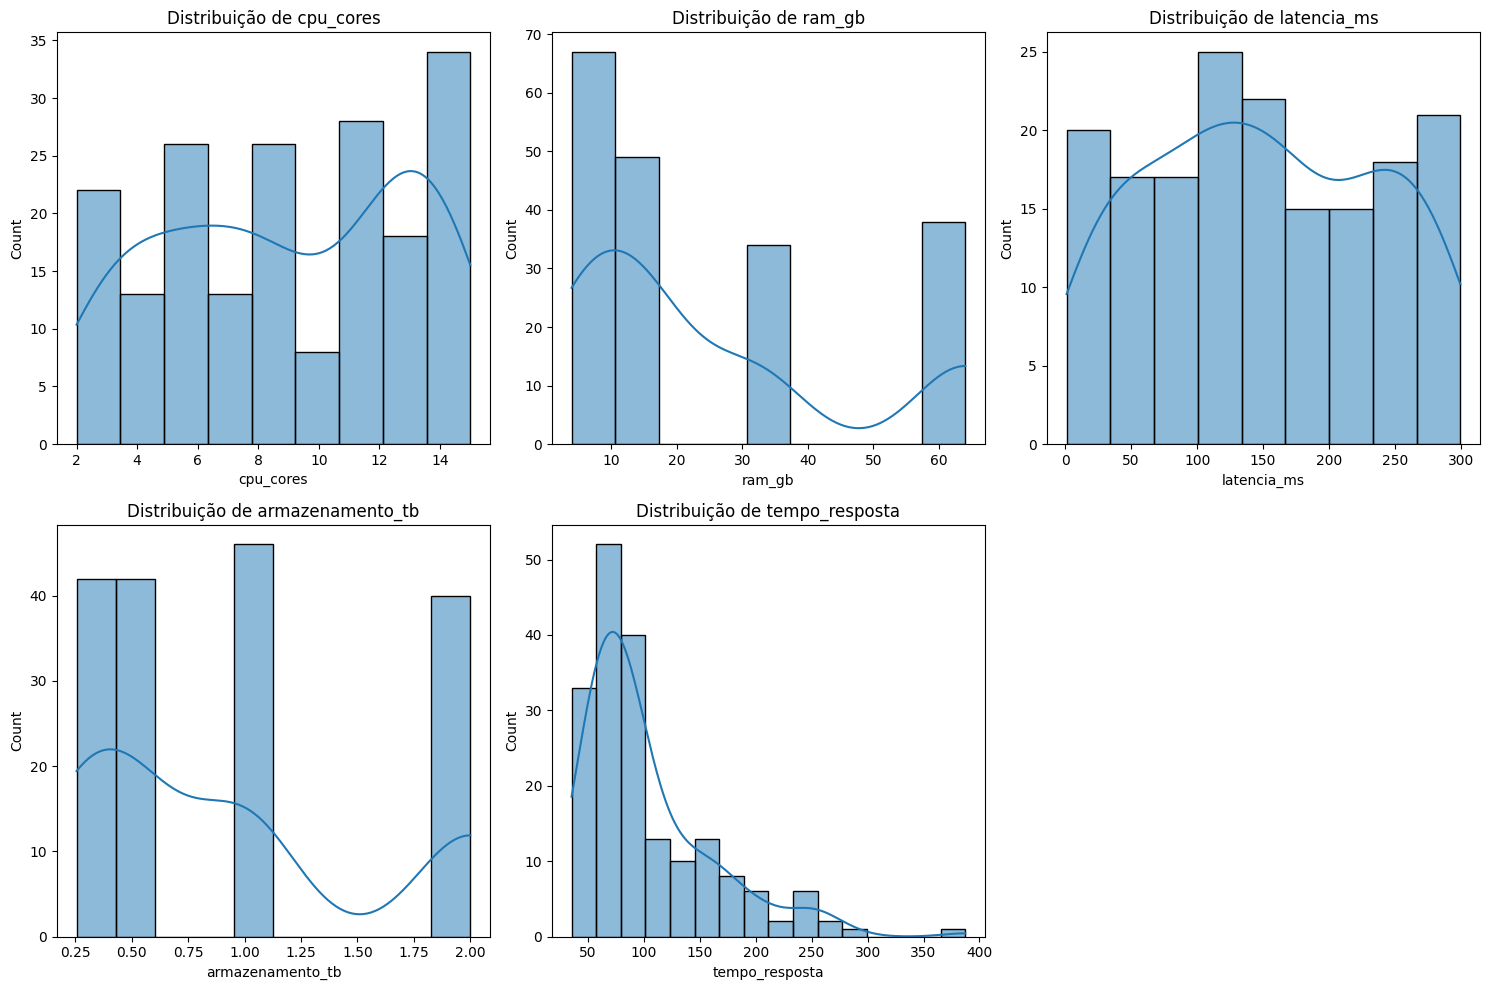

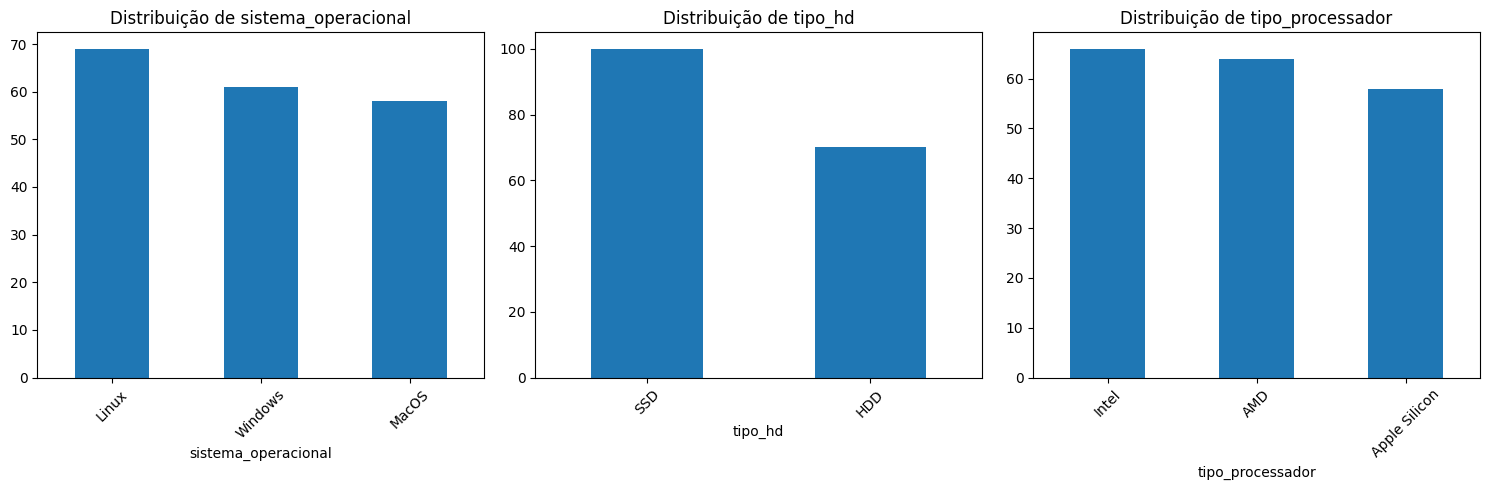

In [3]:
# Visualização da distribuição das variáveis numéricas
num_vars = ['cpu_cores', 'ram_gb', 'latencia_ms', 'armazenamento_tb', 'tempo_resposta']
plt.figure(figsize=(15, 10))
for i, var in enumerate(num_vars, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribuição de {var}')
plt.tight_layout()
plt.show()

# Visualização das variáveis categóricas
cat_vars = ['sistema_operacional', 'tipo_hd', 'tipo_processador']
plt.figure(figsize=(15, 5))
for i, var in enumerate(cat_vars, 1):
    plt.subplot(1, 3, i)
    df[var].value_counts().plot(kind='bar')
    plt.title(f'Distribuição de {var}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Parte II - Modelo e Diagnóstico

                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     74.15
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.23e-52
Time:                        23:39:46   Log-Likelihood:                -888.81
No. Observations:                 187   AIC:                             1796.
Df Residuals:                     178   BIC:                             1825.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

c:\Users\louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


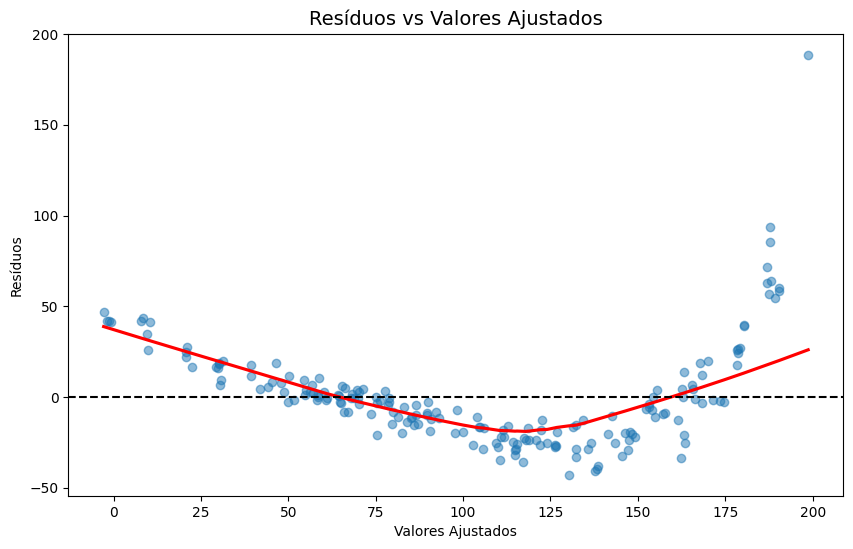


Teste de Breusch-Pagan:
Estatística: 15.5369, p-valor: 0.0772
Sem heterocedasticidade significativa


In [4]:
# Tratar valores nulos em variáveis numéricas com a mediana
numeric_cols = ['cpu_cores', 'ram_gb', 'latencia_ms', 'armazenamento_tb']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())

# Tratar valores nulos em variáveis categóricas com a moda
categorical_cols = ['sistema_operacional', 'tipo_hd', 'tipo_processador']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0]).astype(str)

# Tratar valor nulo em variável dependente (remoção)
df = df.dropna(subset=['tempo_resposta'])

# Codificar variáveis categóricas com dummies (excluindo a primeira categoria)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Converter todas as colunas para tipo float
df_encoded = df_encoded.astype(float)

# Remover colunas completamente nulas (por segurança)
df_encoded = df_encoded.dropna(axis=1, how='all')

# Separar variável dependente e independentes
y = df_encoded['tempo_resposta']
X = df_encoded.drop('tempo_resposta', axis=1)

# Adicionar constante (intercepto) ao modelo
X = sm.add_constant(X)

# Ajustar o modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Exibir o resumo do modelo
print(modelo.summary())

# DIAGNÓSTICO DE MULTICOLINEARIDADE (VIF)
vif_data = pd.DataFrame(columns=['Variável', 'VIF'])

X_numeric = X.select_dtypes(include=[np.number])
X_filtered = X_numeric.loc[:, X_numeric.std() > 1e-6]

for i, col in enumerate(X_filtered.columns):
    try:
        vif = variance_inflation_factor(X_filtered.values, i)
        if np.isfinite(vif):
            vif_data.loc[len(vif_data)] = [col, vif]
    except:
        continue

vif_data = vif_data.sort_values('VIF', ascending=False)
print("\n==========================\nVIF - Multicolinearidade:")
print(vif_data)

# DIAGNÓSTICO DE HETEROCEDASTICIDADE
plt.figure(figsize=(10, 6))
sns.regplot(x=modelo.fittedvalues, y=modelo.resid, lowess=True, 
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Resíduos vs Valores Ajustados', fontsize=14)
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

bp_test = sms.het_breuschpagan(modelo.resid, modelo.model.exog)
print("\n==========================\nTeste de Breusch-Pagan:")
print(f"Estatística: {bp_test[0]:.4f}, p-valor: {bp_test[1]:.4f}")
print("Heterocedasticidade presente" if bp_test[1] < 0.05 else "Sem heterocedasticidade significativa")

### Parte III – Análise Crítica


In [5]:
# MODELO 1: Todas as variáveis
X1 = df_encoded.drop(columns=['tempo_resposta'])
X1 = sm.add_constant(X1)
y = df_encoded['tempo_resposta']
modelo1 = sm.OLS(y, X1).fit()

print("="*80)
print("MODELO 1: COM TODAS AS VARIÁVEIS")
print("="*80)
print(modelo1.summary())

# MODELO 2: Remover 'latencia_ms' (irrelevante com p > 0.8)
X2 = df_encoded.drop(columns=['tempo_resposta', 'latencia_ms'])
X2 = sm.add_constant(X2)
modelo2 = sm.OLS(y, X2).fit()

print("\n" + "="*80)
print("MODELO 2: SEM A VARIÁVEL 'latencia_ms'")
print("="*80)
print(modelo2.summary())

# COMPARATIVO ENTRE MODELOS
print("\n" + "="*80)
print("COMPARATIVO ENTRE OS MODELOS")
print("="*80)
dados_comparacao = {
    'Métrica': ['R²', 'R² Ajustado', 'Estatística F', 'p-valor (F)', 'Número de variáveis'],
    'Modelo 1 (Completo)': [
        round(modelo1.rsquared, 4),
        round(modelo1.rsquared_adj, 4),
        round(modelo1.fvalue, 4),
        f"{modelo1.f_pvalue:.4e}",
        int(modelo1.df_model)
    ],
    'Modelo 2 (Sem latencia_ms)': [
        round(modelo2.rsquared, 4),
        round(modelo2.rsquared_adj, 4),
        round(modelo2.fvalue, 4),
        f"{modelo2.f_pvalue:.4e}",
        int(modelo2.df_model)
    ]
}
df_comparativo = pd.DataFrame(dados_comparacao)
print(df_comparativo.to_string(index=False))


MODELO 1: COM TODAS AS VARIÁVEIS
                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     74.15
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.23e-52
Time:                        23:39:49   Log-Likelihood:                -888.81
No. Observations:                 187   AIC:                             1796.
Df Residuals:                     178   BIC:                             1825.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------